<a href="https://colab.research.google.com/github/Mayurrathod1/Stock_Market_Forcasting/blob/main/Stock_Price_Forecasting__LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5. Long Short-Term Memory (LSTM)**
  LSTMs are specifically designed to remember long-term dependencies in sequential data, which makes them ideal for predicting future values based on past trends. It captures complex patterns and temporal dependencies that linear models may miss. By leveraging memory cells and gates, the LSTM selectively retains relevant information over time, allowing it to model both short-term fluctuations and long-term trends effectively. This results in a robust forecast that adapts to the dynamic patterns in our dataset.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'aapl.csv' is in your current working directory
df = pd.read_csv('/content/AAPL.csv')

# Print the first few rows of the dataframe to verify it's loaded correctly
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [8]:
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [9]:
df1 = df.reset_index()['close']

In [10]:
df1.head()

,close
0,132.045
1,131.780
2,130.280
3,130.535
4,129.960


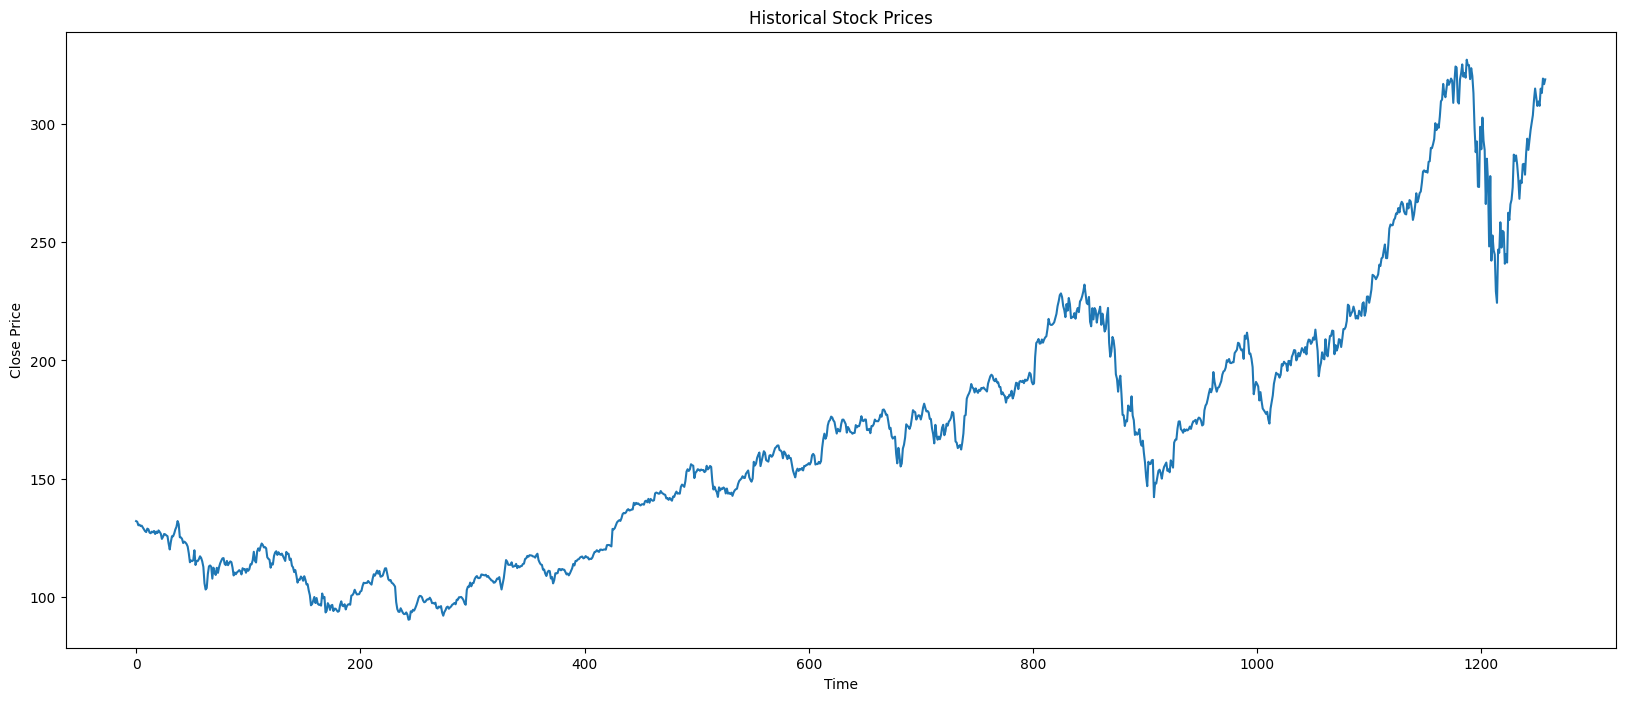

In [11]:
# Plotting
plt.figure(figsize = (20, 8))
plt.plot(df1)
plt.title('Historical Stock Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

In [12]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [14]:
# splitting dataset into train and test split
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(1006, 252)

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(Y_train.shape)

(905, 100)
(905,)


(None, None)

In [19]:
print(X_test.shape), print(Y_test.shape)

(151, 100)
(151,)


(None, None)

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - loss: 0.0439 - val_loss: 0.1155
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0053 - val_loss: 0.0355
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0012 - val_loss: 0.0154
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0011 - val_loss: 0.0196
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 0.0011 - val_loss: 0.0160
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 9.4364e-04 - val_loss: 0.0112
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 8.5842e-04 - val_loss: 0.0124
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 8.2907e-04 - val_loss: 0.0113
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - loss: 7.8814e-04 - val_loss: 0.0109
Epoch 12/100
15/15 ━━━━━━

In [25]:
# For prediction and to check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [26]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [27]:
# R-squared Score
r2_traink = r2_score(Y_train, train_predict)
r2_testk = r2_score(Y_test, test_predict)

# Root Mean Squared Error (RMSE)
rmse_traink = np.sqrt(mean_squared_error(Y_train, train_predict))
rmse_testk = np.sqrt(mean_squared_error(Y_test, test_predict))

print(f"R-squared on Training Data: {r2_traink}")
print(f"R-squared on Testing Data: {r2_testk}")
print(f"RMSE on Training Data: {rmse_traink}")
print(f"RMSE on Testing Data: {rmse_testk}")

R-squared on Training Data: -967247.639651979
R-squared on Testing Data: -6338895.499340465
RMSE on Training Data: 155.31612582248852
RMSE on Testing Data: 285.0628661130317


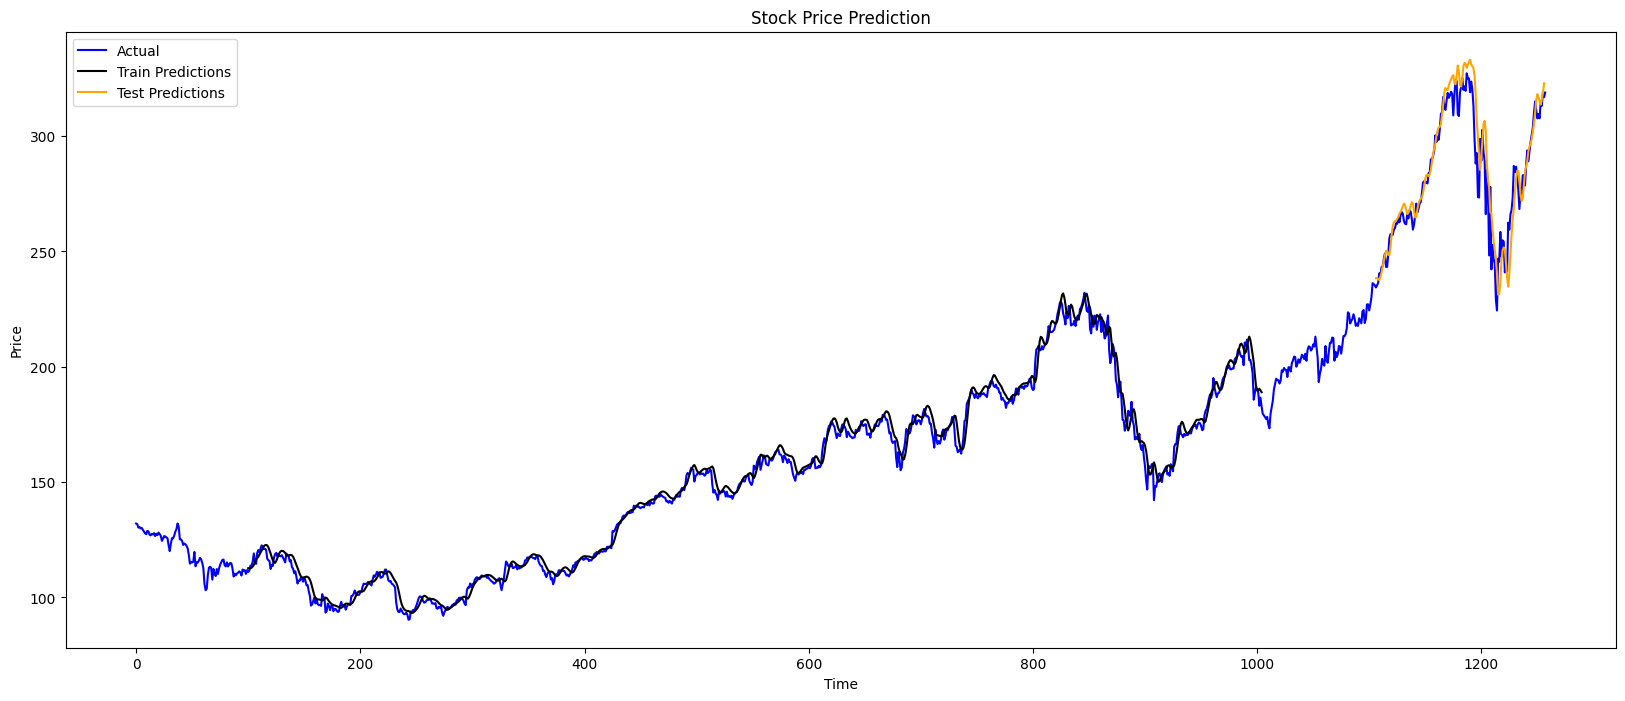

In [28]:
# Plotting
# shift train predictions for plotting
plt.figure(figsize = (20, 8))
look_back=100 # Defining the lookback period (100 timesteps)
trainPredictPlot = np.empty_like(df1) # Creating an empty array with the same shape as df1
trainPredictPlot[:, :] = np.nan # Filling the array with NaN values
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict # Filling with train predictions, shifted by look_back

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1) # Creating an empty array with the same shape as df1
testPredictPlot[:, :] = np.nan # Filling the array with NaN values
testPredictPlot[len(train_predict) + (look_back*2) + 1:len(df1) - 1, :] = test_predict # Filling with test predictions, shifted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), color='blue', label='Actual') # Plotting the original data in blue
plt.plot(trainPredictPlot, color='black', label='Train Predictions') # Plotting train predictions in green
plt.plot(testPredictPlot, color='orange', label='Test Predictions') # Plotting test predictions in red
plt.legend() # Displaying the legend
plt.title('Stock Price Prediction') # Adding a title to the plot
plt.xlabel('Time') # Adding a label for the x-axis
plt.ylabel('Price') # Adding a label for the y-axis
plt.show() # Displaying the plot

In [29]:
len(test_data)

252

In [30]:
x_input = test_data[152:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [32]:
# demonstrate prediction for next 50 days
from numpy import array # Importing the 'array' function from the 'numpy' library

lst_output = [] # Initializing an empty list to store the predicted outputs
n_steps = 100 # Defining the number of time steps (lookback period) for the LSTM model
i = 0 # Initializing a counter variable 'i' to 0

while(i < 50): # Looping 100 times to predict the next 50 days

    if(len(temp_input) > 100): # Checking if the length of 'temp_input' is greater than 100
        # print(temp_input) # (Commented out) Printing 'temp_input' for debugging
        x_input = np.array(temp_input[1:]) # Creating a NumPy array 'x_input' from 'temp_input', excluding the first element
        # print("{} day input {}".format(i,x_input)) # Printing the current day and the input for the LSTM model
        x_input = x_input.reshape(1,-1) # Reshaping 'x_input' to a 2D array with one row and an inferred number of columns
        x_input = x_input.reshape((1, n_steps, 1)) # Reshaping 'x_input' to a 3D array with one sample, 'n_steps' time steps, and one feature
        #print(x_input) # (Commented out) Printing 'x_input' for debugging
        yhat = model.predict(x_input, verbose = 0) # Predicting the next value using the LSTM model
        # print("{} day output {}".format(i,yhat)) # Printing the current day and the predicted output
        temp_input.extend(yhat[0].tolist()) # Extending 'temp_input' with the predicted output
        temp_input = temp_input[1:] # Removing the first element from 'temp_input'
        #print(temp_input) # (Commented out) Printing 'temp_input' for debugging
        lst_output.extend(yhat.tolist()) # Extending 'lst_output' with the predicted output
        i = i + 1 # Incrementing the counter variable 'i'

    else: # If the length of 'temp_input' is less than or equal to 100
        x_input = x_input.reshape((1, n_steps,1)) # Reshaping 'x_input' to a 3D array for the LSTM model
        yhat = model.predict(x_input, verbose=0) # Predicting the next value
        # print(yhat[0]) # Printing the predicted output
        temp_input.extend(yhat[0].tolist()) # Extending 'temp_input' with the predicted output
        # print(len(temp_input)) # Printing the length of 'temp_input'
        lst_output.extend(yhat.tolist()) # Extending 'lst_output' with the predicted output
        i = i + 1 # Incrementing the counter variable 'i'

In [33]:
day_new=np.arange(1,101)
day_pred=np.arange(101,151)

In [34]:
len(df1)

1258

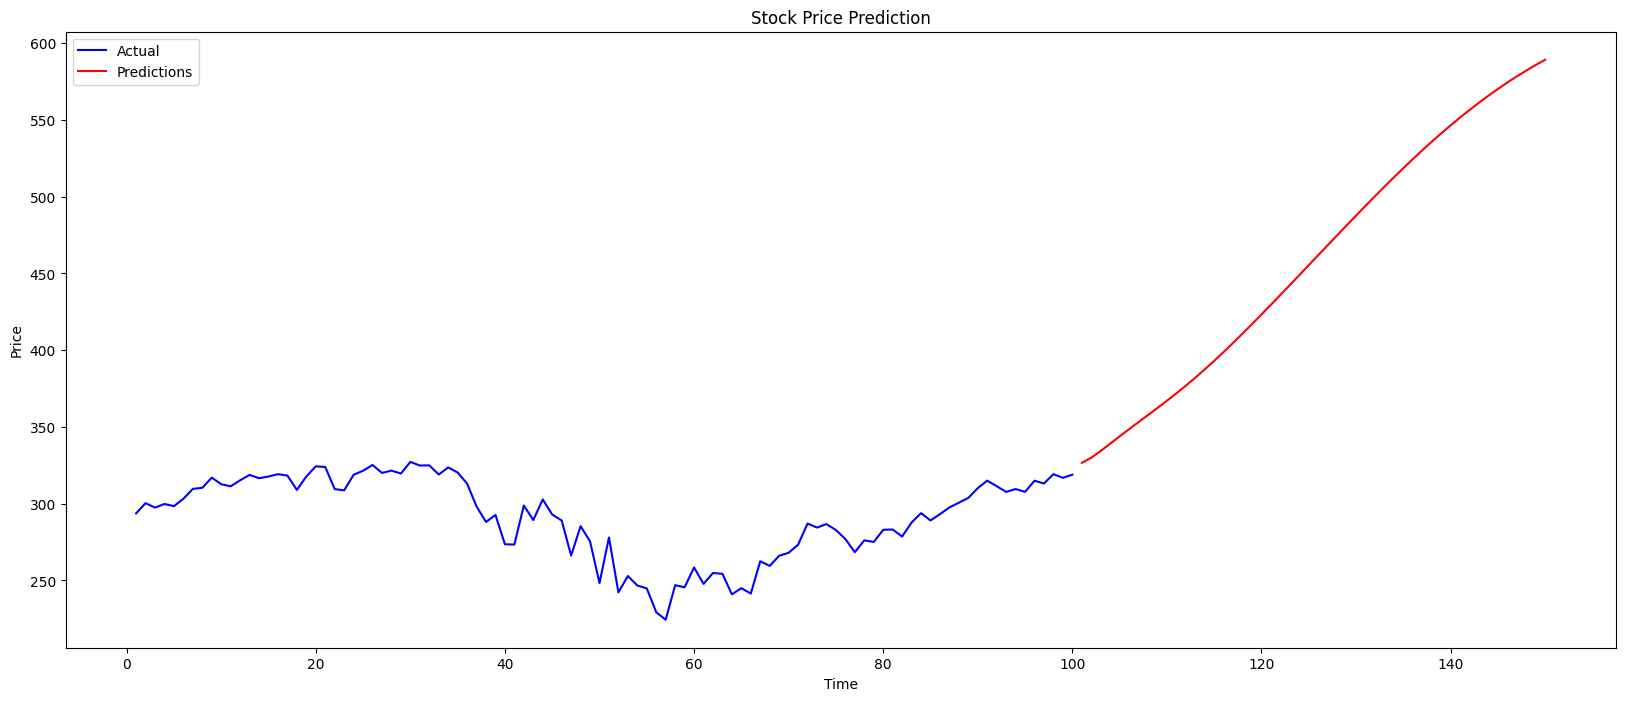

In [49]:
# Plotting
plt.figure(figsize = (20, 8))
plt.plot(day_new, scaler.inverse_transform(df1[1158:]), color='blue', label='Actual') # Plotting actual data in blue
plt.plot(day_pred, scaler.inverse_transform(lst_output), color='red', label='Predictions') # Plotting predictions in red
plt.title('Stock Price Prediction') # Adding a title
plt.xlabel('Time') # Adding x-axis label
plt.ylabel('Price') # Adding y-axis label
plt.legend() # Displaying the legend
plt.show()

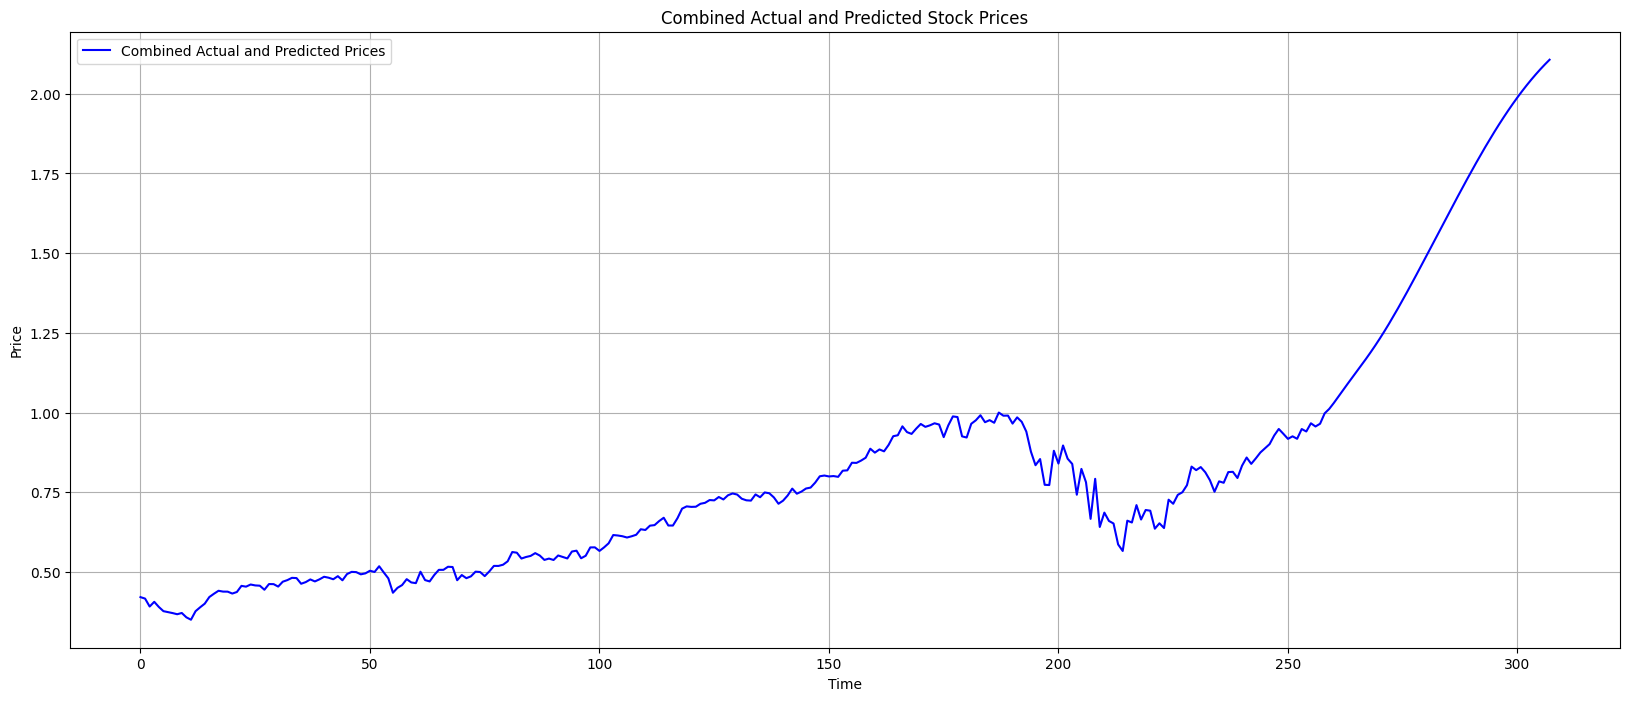

In [50]:
df3 = df1.tolist()
df3.extend(lst_output)

# Plotting the combined actual and predicted prices
plt.figure(figsize=(20, 8))  # Set the figure size for better visualization
plt.plot(df3[1000:], color='blue', label='Combined Actual and Predicted Prices')  # Plot the combined data in blue
plt.title('Combined Actual and Predicted Stock Prices')  # Add a descriptive title
plt.xlabel('Time')  # Label the x-axis as 'Time'
plt.ylabel('Price')  # Label the y-axis as 'Price'
plt.legend()  # Display the legend to identify the data
plt.grid(True)  # Add a grid for better readability
plt.show()  # Show the plot

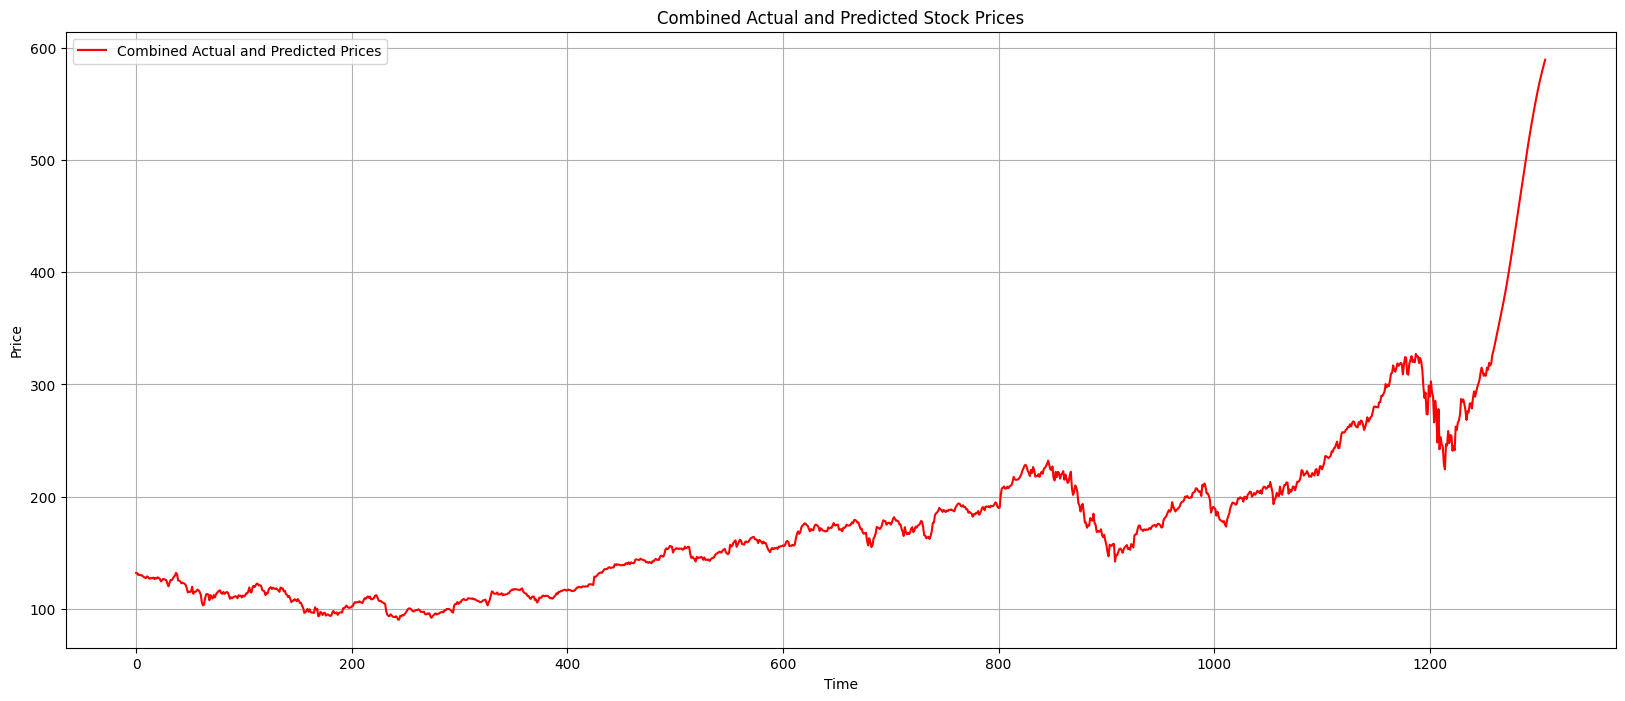

In [51]:
df3=scaler.inverse_transform(df3).tolist()

# Plotting the combined actual and predicted prices
plt.figure(figsize=(20, 8))  # Set the figure size for better visualization
plt.plot(df3, color='red', label='Combined Actual and Predicted Prices')  # Plot the combined data in blue
plt.title('Combined Actual and Predicted Stock Prices')  # Add a descriptive title
plt.xlabel('Time')  # Label the x-axis as 'Time'
plt.ylabel('Price')  # Label the y-axis as 'Price'
plt.legend()  # Display the legend to identify the data
plt.grid(True)  # Add a grid for better readability
plt.show()  # Show the plot